# MASTER - Notebook 3 GTFS
## Gets geocoordinates for each stop and create a new dataset with GTFS 
### Matteo Grazioso 884055

This notebook uses the file stops.txt retrived from https://transitfeeds.com/p/actv/631/20230823 updated at the date of 23 August 2023.
Feeds Europe IT Veneto Venice ACTV Navigazione GTFS.
It is provided by open mobility data, An extensive archive of public transit data for software developers, transit agencies and more.
GTFS (General Transit Feed Specification) is the most commonly used format for specifying public transit schedules. GTFS-realtime is used to specify real-time transit data.

It contais the columns:
- stop_id: The stop_id field contains an ID that uniquely identifies a stop or station. Multiple routes may use the same stop. The stop_id is dataset unique.
- stop_code: The stop_code field contains short text or a number that uniquely identifies the stop for passengers. Stop codes are often used in phone-based transit information systems or printed on stop signage to make it easier for riders to get a stop schedule or real-time arrival information for a particular stop. The stop_code field should only be used for stop codes that are displayed to passengers. For internal codes, use stop_id. This field should be left blank for stops without a code.
- stop_name: The stop_name field contains the name of a stop or station. Please use a name that people will understand in the local and tourist vernacular.
- stop_desc: The stop_desc field contains a description of a stop. Please provide useful, quality information. Do not simply duplicate the name of the stop.
- stop_lat: The stop_lat field contains the latitude of a stop or station. The field value must be a valid WGS 84 latitude.
- stop_lon: The stop_lon field contains the longitude of a stop or station. The field value must be a valid WGS 84 longitude value from -180 to 180.
- zone_id: The zone_id field defines the fare zone for a stop ID. Zone IDs are required if you want to provide fare information using fare_rules.txt. If this stop ID represents a station, the zone ID is ignored.
- stop_url: The zone_id field defines the fare zone for a stop ID. Zone IDs are required if you want to provide fare information using fare_rules.txt. If this stop ID represents a station, the zone ID is ignored.
- location_type: The location_type field identifies whether this stop ID represents a stop or station. If no location type is specified, or the location_type is blank, stop IDs are treated as stops. Stations may have different properties from stops when they are represented on a map or used in trip planning. 0 or blank represents a stop, while 1 represents a station that contains one or more stop.
- parent_station: For stops that are physically located inside stations, the parent_station field identifies the station associated with the stop. To use this field, stops.txt must also contain a row where this stop ID is assigned location type=1
- stop_timezone: The stop_timezone field contains the timezone in which this stop or station is located. Please refer to Wikipedia List of Timezones for a list of valid values. If omitted, the stop should be assumed to be located in the timezone specified by agency_timezone in agency.txt
- wheelchair_boarding: The stop_timezone field contains the timezone in which this stop or station is located. Please refer to Wikipedia List of Timezones for a list of valid values. If omitted, the stop should be assumed to be located in the timezone specified by agency_timezone in agency.txt

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import re
import os

from pandas import Timestamp
import json
import warnings
warnings.filterwarnings('ignore')

import datetime

import myfunctions as mf # Custom functions

In [2]:
# Disply all columns and all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Dataset restriction

This notebbok open the dataset in which is already applied the temporal data cleaning

The notebook allows you to restrict the dataset to a specific time period (e.g. before Carnival, during Carnival, after Carnival) and export the dataset in a txt file 

In [3]:
def restrict_dataset_to_period(df, start_date, end_date):
    '''
    Restrict the dataset to only the specified period given by the user
        :param df: the dataset to be restricted
        :param start_date: the start date of the period
        :param end_date: the end date of the period
        :return: the restricted dataset        
    ''' 

    # Filter the dataset to only the specified period
    df = df[(df['DATA'] >= start_date) & (df['DATA'] <= end_date)]
    
    return df

In [10]:
# path = 'data/processed/dataset_cleaned_tempesportazioneCompleta.txt'
# path = 'data/processed/dataset_cleaned_tempvalidazioni.txt'
# path = 'data/processed/dataset_cleaned_tempesportazionePasqua23_part1.txt'
# path = 'data/processed/dataset_cleaned_tempesportazionePasqua23_part2.txt'
path = 'data/processed/dataset_cleaned_temp_esportazioneFineAgosto2023_part1.txt'
# path = 'data/processed/dataset_cleaned_temp_esportazioneFineAgosto2023_part2.txt'

df = pd.read_csv(path, header=0, sep='\t')

# Save the name of the file in a variable for future use extracting the name of the file from the path
file_name = path.split('_')[-1].split('.')[0]

subfolder = file_name
print(file_name)

# Display the first 5 rows of the dataframe
print(df.head())

# Convert the column 'DATA' to datetime format
df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')

part1
         DATA       ORA     DATA_VALIDAZIONE     SERIALE  FERMATA  \
0  2023-09-02  08:23:00  2023-09-02 08:23:00 -4090155587     5113   
1  2023-09-03  18:22:00  2023-09-03 18:22:00 -4090155587     5113   
2  2023-09-10  07:51:00  2023-09-10 07:51:00 -4090155587     5113   
3  2023-09-07  10:38:00  2023-09-07 10:38:00 -4090155586     6011   
4  2023-08-29  15:46:00  2023-08-29 15:46:00 -4090155583     5028   

    DESCRIZIONE  TITOLO TICKET_CODE           DESCRIZIONE_TITOLO  
0    Burano "C"   21403       6-RET  ABBONAMENTO PENSIONATI ACTV  
1    Burano "C"   21403       6-RET  ABBONAMENTO PENSIONATI ACTV  
2    Burano "C"   21403       6-RET  ABBONAMENTO PENSIONATI ACTV  
3  San Dona' Ri   21403       6-RET  ABBONAMENTO PENSIONATI ACTV  
4  P.le Roma "E   21403       6-RET  ABBONAMENTO PENSIONATI ACTV  


In [11]:
df.tail(100)

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
1555381,2023-08-25,11:08:00,2023-08-25 11:08:00,-2821761695,6080,MESTRE CENTR,23102,6,ANNUALE ORDINARIO RETE UNICA
1555382,2023-08-27,11:35:00,2023-08-27 11:35:00,-2821761695,81,Einaudi Cast,23102,6,ANNUALE ORDINARIO RETE UNICA
1555383,2023-08-28,11:57:00,2023-08-28 11:57:00,-2821761695,246,Garibaldi Mu,23102,6,ANNUALE ORDINARIO RETE UNICA
1555384,2023-08-28,10:52:00,2023-08-28 10:52:00,-2821761695,384,Mestre Centr,23102,6,ANNUALE ORDINARIO RETE UNICA
1555385,2023-08-28,11:27:00,2023-08-28 11:27:00,-2821761695,12,Mestre Via M,23102,6,ANNUALE ORDINARIO RETE UNICA
1555386,2023-08-30,10:04:00,2023-08-30 10:04:00,-2821761695,6023,Ca' Rossa Vo,23102,6,ANNUALE ORDINARIO RETE UNICA
1555387,2023-08-30,10:47:00,2023-08-30 10:47:00,-2821761695,6080,MESTRE CENTR,23102,6,ANNUALE ORDINARIO RETE UNICA
1555388,2023-08-30,10:11:00,2023-08-30 10:11:00,-2821761695,384,Mestre Centr,23102,6,ANNUALE ORDINARIO RETE UNICA
1555389,2023-08-30,10:38:00,2023-08-30 10:38:00,-2821761695,382,Porto Marghe,23102,6,ANNUALE ORDINARIO RETE UNICA
1555390,2023-08-31,11:23:00,2023-08-31 11:23:00,-2821761695,6034,Cappuccina B,23102,6,ANNUALE ORDINARIO RETE UNICA


In [12]:
dict_tickets = {'1': 'One-day ticket', '2': 'Two-day ticket', '3': 'Three-day ticket', 
                '4': 'Seven-day ticket', 
                '5': 'Monthly ticket', '5-STUD': 'Monthly ticket for students',
                '5-RET': 'Monthly ticket for retired', '5-WKRS': 'Monthly ticket for workers',
                '6': 'Annual ticket', '6-STUD': 'Annual ticket for students', '6-RET': 'Annual ticket for retired',
                '6-WKRS': 'Annual ticket for workers',
                '7': '75 minutes ticket', '8': 'Other ticket'}

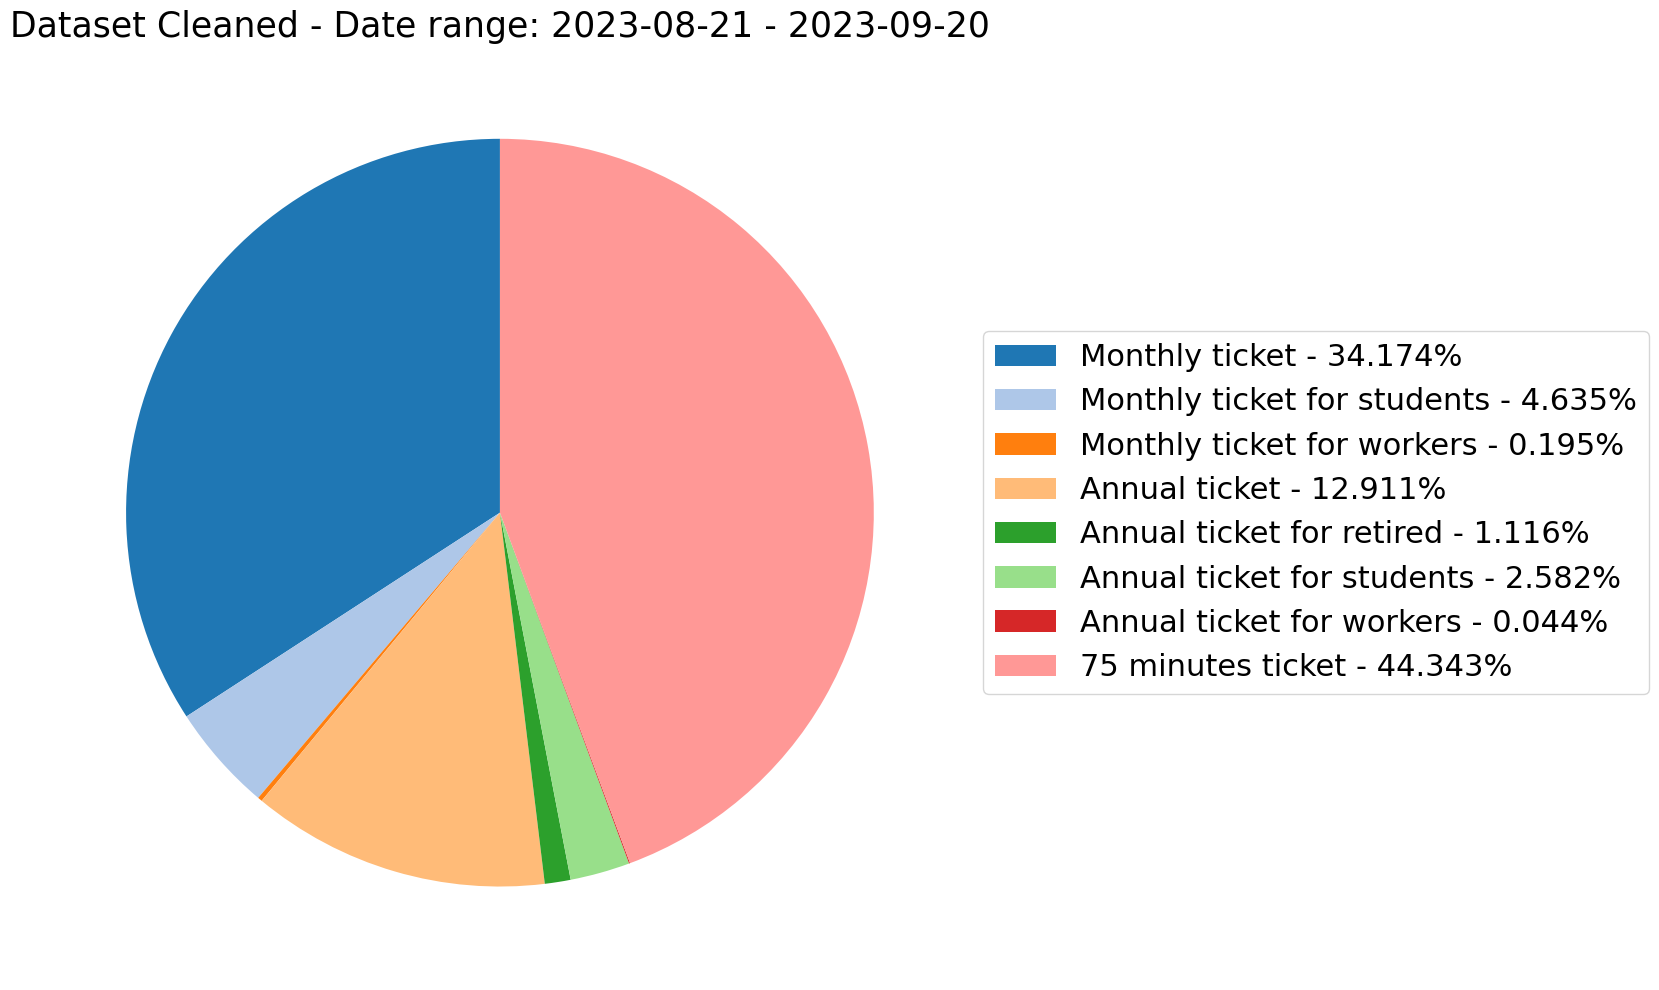

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert index to strings before sorting
df['TICKET_CODE'] = df['TICKET_CODE'].astype(str)

fig, ax = plt.subplots(figsize=(20,10))
# Change palette to have more colors
sns.set_palette("tab20")
df['TICKET_CODE'].value_counts().sort_index().plot.pie(startangle=90)

plt.title('Dataset Cleaned - Date range: ' + str(df['DATA'].min().to_pydatetime().date()) + ' - ' + str(df['DATA'].max().to_pydatetime().date()), fontsize=25)
plt.ylabel('')

# Modify the legend to have the description of the ticket profile and the percentage of each category appended
handles, labels = ax.get_legend_handles_labels()
labels = [s + ' - {:.3f}%'.format(100*v/len(df)) for s, v in zip(df['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).index, df['TICKET_CODE'].value_counts().sort_index())]
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=22)

# Ensure that the labels are not overlapped on the pie chart
plt.tight_layout()

# Remove the labels on the pie chart
texts = [text for text in ax.texts]
for text in texts:
    text.set_visible(False)

fig.patch.set_facecolor('white')
plt.show()


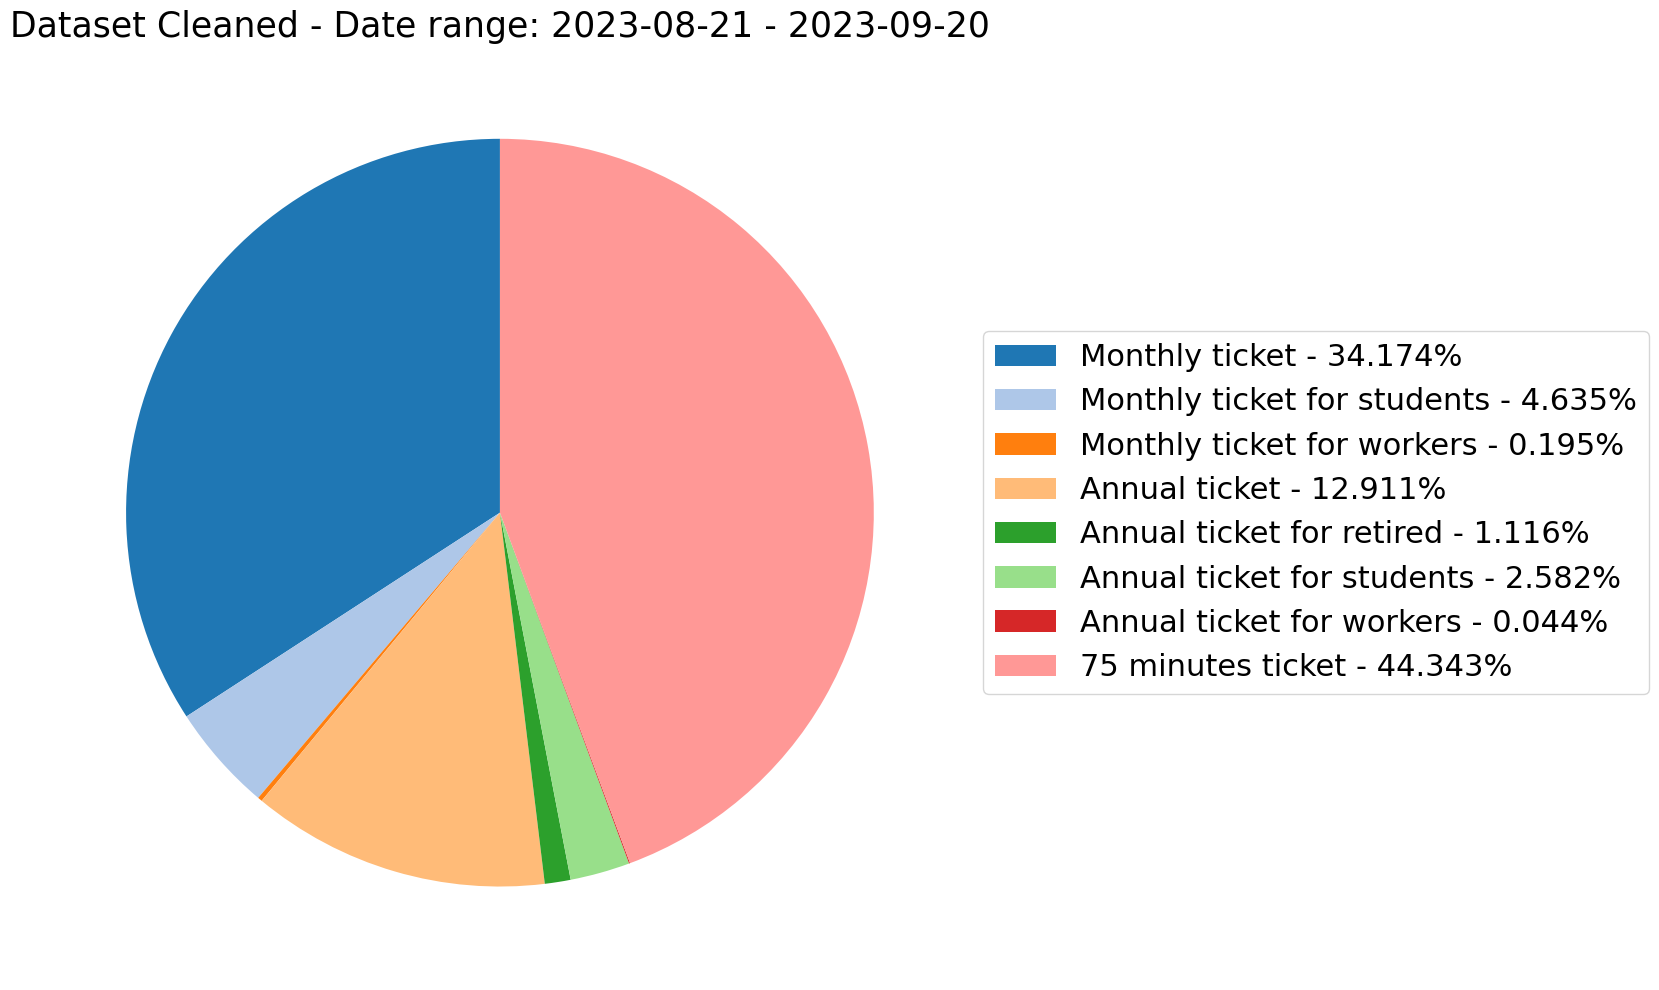

In [14]:
# Plot a pie chart of the column 'TICKET_CODE'
fig, ax = plt.subplots(figsize=(20,10))
# Change palette to have more more colors
sns.set_palette("tab20")
df['TICKET_CODE'].value_counts().sort_index().plot.pie(startangle=90)

plt.title('Dataset Cleaned - Date range: ' + str(df['DATA'].min().to_pydatetime().date()) + ' - ' + str(df['DATA'].max().to_pydatetime().date()), fontsize=25)
plt.ylabel('')

# Modify the legend to have the description of the ticket profile and the percentage of each category appended
handles, labels = ax.get_legend_handles_labels()
labels = [s + ' - {:.3f}%'.format(100*v/len(df)) for s, v in zip(df['TICKET_CODE'].value_counts().sort_index().rename(dict_tickets).index, df['TICKET_CODE'].value_counts().sort_index())]
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=22)

# Ensure that the labels are not overlapped on the pie chart
plt.tight_layout()

# Remove the labels on the pie chart
texts = [text for text in ax.texts]
for text in texts:
    text.set_visible(False)

fig.patch.set_facecolor('white')
plt.show()

In [ ]:
# Ask in input if the user wants to restrict the analysis to a specific period (Before carnival, during carnival, after carnival)
# If the user wants to restrict the analysis, the user has to specify the number of the period (1, 2, 3)
# If the user doesn't want to restrict the analysis, the user has to specify the number 0

if file_name == 'tempesportazioneCompleta':
    while True:
        input_period = input("Do you want to restrict the analysis to a specific period? (Yes/No) ")
        if input_period == "Yes" or input_period == "yes" or input_period == "Y" or input_period == "y":
            while True:
                input_period_number = input("Which period do you want to restrict the analysis to? (1: Before Carnival, 2: During Carnival, 3: After Carnival) ")
                if not input_period_number.isdigit():
                    print("Enter a valid number.")
                    continue
                input_period_number = int(input_period_number)
                if input_period_number == 1:
                    period = "before_carnival"
                    break
                elif input_period_number == 2:
                    period = "during_carnival"
                    break
                elif input_period_number == 3:
                    period = "after_carnival"
                    break
                else:
                    print("You have to specify a number between 1 and 3!")
                    continue
            break
        elif input_period == "No" or input_period == "no" or input_period == "N" or input_period == "n":
            period = "All the period"
            input_period_number = 0
            break
        else:
            print("You have to specify Yes or No!")
            continue

    if input_period_number == 1:
        print("You have chosen to restrict the analysis to the period before Carnival.")
        print("Date range: 2023-01-17 to  2023-02-03")
        df = restrict_dataset_to_period(df, '2023-01-17', '2023-02-03')
    elif input_period_number == 2:
        print("You have chosen to restrict the analysis to the period during Carnival.")
        print("Date range: 2023-02-04 to 2023-02-21")
        df = restrict_dataset_to_period(df, '2023-02-04', '2023-02-21')
    elif input_period_number == 3:
        print("You have chosen to restrict the analysis to the period after Carnival.")
        print("Date range: 2023-02-22 to 2023-03-12")
        df = restrict_dataset_to_period(df, '2023-02-22', '2023-03-12')

elif file_name == 'part1':
    while True:
        input_period = input("Do you want to restrict the analysis to a specific period? (Yes/No) ")
        if input_period == "Yes" or input_period == "yes" or input_period == "Y" or input_period == "y":
            while True:
                input_period_number = input("Which period do you want to restrict the analysis to? (2: During Easter, 3: After Easter) ")
                if not input_period_number.isdigit():
                    print("Enter a valid number.")
                    continue
                input_period_number = int(input_period_number)
                if input_period_number == 2:
                    period = "during_easter"
                    break
                elif input_period_number == 3:
                    period = "after_easter"
                    break
                else:
                    print("You have to specify a number between 2 and 3!")
                    continue
            break
        elif input_period == "No" or input_period == "no" or input_period == "N" or input_period == "n":
            period = "All the period"
            input_period_number = 0
            break
        else:
            print("You have to specify Yes or No!")
            continue

    if input_period_number == 2:
        print("You have chosen to restrict the analysis to the period during Easter.")
        print("Date range: 2023-04-04 to 2023-04-16")
        df = restrict_dataset_to_period(df, '2023-04-04', '2023-04-16')
    elif input_period_number == 3:
        print("You have chosen to restrict the analysis to the period after Easter.")
        print("Date range: 2023-04-17 to 2023-05-03")
        df = restrict_dataset_to_period(df, '2023-04-17', '2023-05-03')

else:
    period = "All the period"
    print("You have chosen to analyse the entire period.")
    input_period_number = 0

In [ ]:
# Print teh range of dates
print(f"Date range: {df['DATA'].min()} - {df['DATA'].max()}")

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
print(period)
print(file_name)

# Export the dataframe to a txt file
# Check if the file already exists
if input_period_number == 1 or input_period_number == 2 or input_period_number == 3:
    if not os.path.exists('data/processed/dataset_cleaned_temp_' + period + '_' + file_name + '.txt'):
        df.to_csv('data/processed/dataset_cleaned_temp_' + period + '_' + file_name + '.txt', sep='\t', index=False)
        print("The file has been created in the folder data/processed/dataset_cleaned_temp_" + period + '_' + file_name + '.txt')
    else:
        print("The file already exists in the folder data/processed/dataset_cleaned_temp_" + period + '_' + file_name + '.txt')
        df = pd.read_csv('data/processed/dataset_cleaned_temp_' + period + '_' + file_name + '.txt', header=0, sep='\t')

## GTFS


In [ ]:
# Change same FERMATA values in order to correct the errors in the dataset (decided in a meeting on 1st September 2023)
# Change all FERMATA 15108 to FERMATA 5108
df['FERMATA'] = df['FERMATA'].replace(15108, 5108)

# Change all FERMATA 15009 to FERMATA 5009
df['FERMATA'] = df['FERMATA'].replace(15009, 5009)

# Change all FERMATA 15049 to FERMATA 5049
df['FERMATA'] = df['FERMATA'].replace(15049, 5049)

# Change all FERMATA 15083 to FERMATA 5083
df['FERMATA'] = df['FERMATA'].replace(15083, 5083)

In [ ]:
# Open the file data/processed/data-GTFS/stops.txt that is a GTFS file
stops = pd.read_csv('data/processed/data-GTFS/stops.txt', header=0, sep=',')
stops.head()

In [ ]:
# Mantain only the columns 'stop_id', 'stop_name', 'stop_lat', 'stop_lon'
stops = stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
stops.head()

In [ ]:
df.head()

In [ ]:
# Merge the two dataframes df and stops on the column 'FERMATA' and 'stop_id'
df = pd.merge(df, stops, left_on='FERMATA', right_on='stop_id', how='left')
df.head()

In [ ]:
df.head()

In [ ]:
# If the column 'stop_name' is not NaN, sobstitute the value of the column 'DESCRIZIONE' with the value of the column 'stop_name' 
# because this column contains the full name of the stop while the column 'FERMATA' contains a truncated name of the stop
df['DESCRIZIONE'] = np.where(df['stop_name'].notnull(), df['stop_name'], df['DESCRIZIONE'])

In [ ]:
# Remove the column 'stop_id' and 'stop_name'
df.drop(['stop_id', 'stop_name'], axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
# Reorder the columns in order to have the column 'stop_lat' and 'stop_lon' after the column 'DESCRIZIONE' 
df = df[['DATA', 'ORA', 'DATA_VALIDAZIONE', 'SERIALE', 'FERMATA', 'stop_lat', 'stop_lon', 'DESCRIZIONE', 'TITOLO', 'TICKET_CODE', 'DESCRIZIONE_TITOLO']]
df.head()

In [ ]:
# Print the number of unique values of FERMATA that have a NaN value in the column 'stop_lat' (TERRA)
print(f"Number of unique values of FERMATA that have a NaN value in the column 'stop_lat' (TERRA): {df[df['stop_lat'].isnull()]['FERMATA'].nunique()}")

# Print the number of unique values of FERMATA that don't have a NaN value in the column 'stop_lat' (NAVIGAZIONE VENEZIA)
print(f"Number of unique values of FERMATA that don't have a NaN value in the column 'stop_lat' (NAVIGAZIONE VENEZIA): {df[df['stop_lat'].notnull()]['FERMATA'].nunique()}")

In [ ]:
# Open the file data/processed/data-GTFS/stop_aggr.json
with open('data/processed/data-GTFS/stop_aggr.json') as json_file:
    stop_aggr = json.load(json_file)

# Convert the key to integer
stop_aggr = {int(k):v for k,v in stop_aggr.items()}

# Stop_aggr is a dictionary with the following structure:
# fermata:id_stop_aggr

In [ ]:
print(stop_aggr)

In [ ]:
# Create a new column 'stop_aggr' in the dataframe df and fill it with the values of the dictionary stop_aggr
# The key of the dictionary is the value of the column 'FERMATA' and the value of the dictionary is the value of the column 'stop_aggr'
# Print
df['stop_aggr'] = df['FERMATA'].map(stop_aggr)
df.head()

In [ ]:
# Look for Murano in the column 'DESCRIZIONE'
# df[df['DESCRIZIONE'].str.contains('Mestre Stazi')]

In [ ]:
# Set stop_aggr as int where it is possible
df['stop_aggr'] = df['stop_aggr'].astype('Int64')

In [ ]:
# Open the file data/processed/data-GTFS/stop_all.json
# stop_all is a dictionary with the following structure:
# id_stop: description, lat, lon and I use it to fill the NaN values of the columns 'stop_lat' and 'stop_lon'

with open('data/processed/data-GTFS/stop_all.json') as json_file:
    stop_all = json.load(json_file)

print(stop_all)

In [ ]:
# Fill the column 'FERMATA' with the value of the column 'stop_aggr' only where the column 'stop_aggr' is different from the column 'FERMATA', otherwise leave the value of the column 'FERMATA'
# Ignore the case where the column 'stop_aggr' is NaN
df['FERMATA'] = np.where((df['stop_aggr'].notnull()) & (df['stop_aggr'] < 0), df['stop_aggr'], df['FERMATA'])

In [ ]:
# Convert the key to integer
stop_all = {int(k):v for k,v in stop_all.items()}

In [ ]:
# Set stop_aggr to some FERMATA values (decided in a meeting on 1st September 2023)
# 25->-3 (Ca' Marcello), 27->-2 (Tronchetto), 28->-2 (Tronchetto), 30->-3 (Stazione Mestre),
# 34->-4 (Aeroporto), 36->-3 (Stazione Mestre), 7777->-2 People Mover, 

# 4501->-5 (Klinger), 4502->-5 (Klinger), 4640->-5 (Alberoni), 4645->-5 (Klinger), 4646->-5 (Klinger), 

# 5075->-5 (S. Pietro in)


df['FERMATA'] = df['FERMATA'].replace(25, -3)
df['FERMATA'] = df['FERMATA'].replace(27, -2)
df['FERMATA'] = df['FERMATA'].replace(28, -2)
df['FERMATA'] = df['FERMATA'].replace(30, -3)
df['FERMATA'] = df['FERMATA'].replace(34, -4)
df['FERMATA'] = df['FERMATA'].replace(36, -3)
df['FERMATA'] = df['FERMATA'].replace(7777, -2)
df['FERMATA'] = df['FERMATA'].replace(4501, -5)
df['FERMATA'] = df['FERMATA'].replace(4502, -5)
df['FERMATA'] = df['FERMATA'].replace(4640, -5)
df['FERMATA'] = df['FERMATA'].replace(4645, -5)
df['FERMATA'] = df['FERMATA'].replace(4646, -5)
df['FERMATA'] = df['FERMATA'].replace(5075, -5)

# Where stop_aggr is null and FERMATA has one of the codes above, set stop_aggr to the value of FERMATA
df['stop_aggr'] = np.where((df['stop_aggr'].isnull()) & (df['FERMATA'] == -3), -3, df['stop_aggr'])
df['stop_aggr'] = np.where((df['stop_aggr'].isnull()) & (df['FERMATA'] == -2), -2, df['stop_aggr']) 
df['stop_aggr'] = np.where((df['stop_aggr'].isnull()) & (df['FERMATA'] == -4), -4, df['stop_aggr'])
df['stop_aggr'] = np.where((df['stop_aggr'].isnull()) & (df['FERMATA'] == -5), -5, df['stop_aggr'])

In [ ]:
# If there are NaN values in the column 'stop_aggr', set FERMATA to -1 (TERRA)
df['FERMATA'] = np.where(df['stop_aggr'].isnull(), -1, df['FERMATA'])

# Where stop_aggr is null and FERMATA has -1, set stop_aggr to -1
df['stop_aggr'] = np.where((df['stop_aggr'].isnull()) & (df['FERMATA'] == -1), -1, df['stop_aggr'])

In [ ]:
# If there are some NaN values in the column 'stop_aggr', print a warning in red, else print a message in green that all stops are mapped
if df['stop_aggr'].isnull().sum() > 0:
    print("\033[91mWARNING: There are some NaN values in the column 'stop_aggr'!\033[0m")
else:
    print("\033[92mAll stops are mapped!\033[0m")

In [ ]:
# Change the values of 'DESCRIZIONE', 'stop_lat', 'stop_lon' with the values of the dictionary stop_all
# The structure of the dictionary stop_all is the following:
# fermata: [DESCRIZIONE, stop_lat, stop_lon]
for key, value in stop_all.items():
    df.loc[df['FERMATA'] == key, 'DESCRIZIONE'] = value[0]
    df.loc[df['FERMATA'] == key, 'stop_lat'] = value[1]
    df.loc[df['FERMATA'] == key, 'stop_lon'] = value[2]

df.head()

In [ ]:
df.tail()

In [ ]:
# Print all uniques values of 'FERMATA' with description that contains murano
print(df[df['DESCRIZIONE'].str.contains('murano', case=False)]['DESCRIZIONE'].unique())

print(df[df['DESCRIZIONE'].str.contains('murano', case=False)]['FERMATA'].unique())


In [ ]:
# Remove the column 'stop_aggr'
df.drop(['stop_aggr'], axis=1, inplace=True)

In [ ]:
print(path)

In [ ]:
print(file_name)

In [ ]:
# The path of the file is something like: data/processed/dataset_cleaned_tempesportazionePasqua23_part1.txt
# Export the dataframe to a txt file in the folder data/processed/data-GTFS/dataset_cleaned_temp_GTFS_esportazionePasqua23_part1.txt

# Extract the name of the file from the path: it is all characters betwen '_temp' and '.txt'
file_name = path.split('_temp')[-1].split('.txt')[0]
print(file_name)

# Create the path of the file
path_export = f"data/processed/data-GTFS/Easter/{file_name}" + "_GTFS.txt"
print(path_export)

# Export the dataframe to a txt file in the folder data/processed/data-GTFS/
df.to_csv(path_export, sep='\t', index=False)
print(f"File exported to {path_export}")